# Tactical Asset Allocation

In [2]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [3]:
from pytaa.tools.data import get_strategy_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import EqualWeights, RiskParity, vigilant_allocation
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester
from pytaa.tools.utils import ledoit_wolf_constant_correlation


import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [4]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [87]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=signal_1.index, columns=signal_1.columns)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, strategy.risk_assets, strategy.safe_assets), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# gem dual momentum
strategy = pipeline.gdm
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).classic_momentum(start=12, end=0)
cond_1, cond_2 = signal["SPY"].ge(signal["BIL"]), signal["SPY"].ge(signal["EFA"])
spy = np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
efa = np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
agg = np.where(~cond_1, 1, 0).reshape(-1,1)
weights = pd.DataFrame(np.hstack([spy, efa, agg]), index=signal.index, columns=["SPY", "EFA", "AGG"])
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# diversified gem dual momentum
strategy = pipeline.dgdm
strategy_data = data[strategy.get_tickers()]
mom_periods = [6, 7, 8, 9, 10, 11, 12]
monthly = strategy_data.resample("BM").last()
spy, agg, efa = np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1)), np.zeros((monthly.shape[0], 1))

for w in mom_periods:
    signal = Signal(strategy_data).classic_momentum(start=w, end=0)
    cond_1, cond_2 = signal["SPY"].ge(signal["AGG"]), signal["SPY"].ge(signal["EFA"])
    spy += np.where(cond_1 & cond_2, 1, 0).reshape(-1,1)
    efa += np.where(cond_1 & ~cond_2, 1, 0 ).reshape(-1,1)
    agg += np.where(~cond_1, 1, 0).reshape(-1,1)

weights = pd.DataFrame(np.hstack([spy, efa, agg]) / len(mom_periods), index=monthly.index, columns=monthly.columns)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [116]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,GDM,DGDM
Date,,,,,,,
2022-12-30,1.754711,1.692907,1.097116,2.111553,1.802854,1.184458,1.725633
2023-01-31,1.759507,1.760574,1.115332,2.191896,1.807781,1.240703,1.856736
2023-02-28,1.732300,1.706162,1.114228,2.135632,1.739040,1.213995,1.808180
2023-03-31,1.749544,1.709131,1.120269,2.134504,1.778533,1.241565,1.848216
2023-04-28,1.758973,1.708401,1.123965,2.159475,1.742403,1.250724,1.857050


In [117]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12,GDM,DGDM
Date,,,,,,,
2022-12-30,1.519112,1.391531,1.009019,1.746504,1.539062,0.933195,1.381491
2023-01-31,1.523264,1.447152,1.025773,1.812957,1.543268,0.977509,1.486448
2023-02-28,1.496750,1.400970,1.021320,1.764938,1.483953,0.956467,1.444565
2023-03-31,1.507242,1.398532,1.023846,1.759119,1.511815,0.974425,1.473491
2023-04-28,1.512155,1.396400,1.023324,1.778218,1.480613,0.981613,1.477352


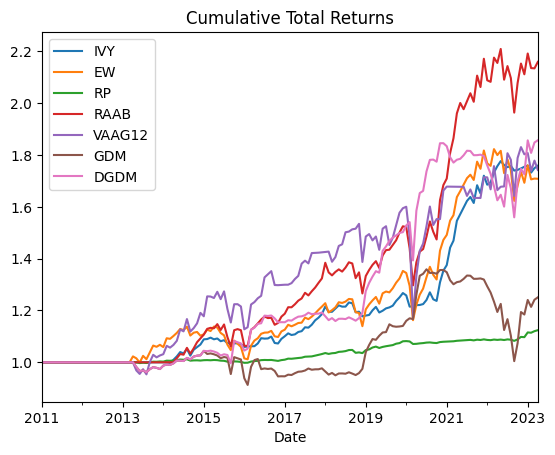

In [118]:
port_total_returns.add(1).cumprod().plot(title="Cumulative Total Returns");

In [119]:
Tearsheet(port_total_returns).summary(ann_factor=12).round(2)

,IVY,EW,RP,RAAB,VAAG12,GDM,DGDM
#obs,148.00,148.00,148.00,148.00,148.00,148.00,148.00
#years,12.24,12.24,12.24,12.24,12.24,12.24,12.24
Total Return,0.76,0.71,0.12,1.16,0.74,0.25,0.86
Annual. Return,0.05,0.04,0.01,0.06,0.05,0.02,0.05
Volatility,0.05,0.08,0.01,0.09,0.12,0.08,0.09
MaxDD,-0.04,-0.14,-0.01,-0.15,-0.27,-0.26,-0.16
Skewness,0.95,-0.53,0.89,-0.18,-1.13,0.52,1.53
Kurtosis,6.73,6.83,11.36,6.05,12.54,9.47,11.75
Sharpe Ratio,1.01,0.59,0.95,0.74,0.43,0.26,0.62
StdErr,0.26,0.30,0.28,0.30,0.31,0.28,0.26
